<a href="https://colab.research.google.com/github/DkCodeProjct/AI_Projects..-/blob/main/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
#
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [61]:
np.random.seed(1337)
random.seed(1337)

#Value Object

     when take _backward deravative


In [44]:

class Value:
    def __init__(self, data, _childrn=(), _op=''):
        self.data = data
        self.grad = 0
        self._op = _op
        self._prev = set(_childrn)
        self.backward = lambda:None

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        output = Value(self.data + self.data, (self, other), '+')

        def _backward():
            self.grad += output.grad
            other.grad += output.grad

        output._backward = _backward

        return output

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        output = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * output.grad  # Chain rule
            other.grad += self.data * output.grad  # Chain rule
        output._backward = _backward
        return output


    def __pow__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        output = Value(self.data**self.data, (self, ), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * output.grad
        output._backward = _backward

        return output

    def relu(self): # x if x>0 else 0 // ReLU
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out


    def backward(self):
        topo = []
        visited = set()
        def buildTopo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    buildTopo(child)
                topo.append(v)
        buildTopo(self)

        self.grad == 1
        for v in reversed(topo):
            v._backward()



    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __rmul__(self, other):
        return self * other

    def __repr__(self) -> str:
        return f'Value(data={self.data}, grad={self.grad})'



#Neuron / Layer / MLP. Objects

In [45]:


class Module:
    def zeroGrad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

class Neuron(Module):
    def __init__(self, nIn, nonlin=True):
        self.w = [Value(random.uniform(-1,1) for _ in range(nIn))]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        return act.relu() if self.nonlin else act

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'Relu ' if self.nonlin else 'Linear'} Neuron{len(self.w)}"

class Layer:
    def __init__(self, nIn, nout, **kwargs):
        self.neurons = [Neuron(nIn, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layers of [{', '.join(str(n) for n in self.neurons)}]"

class MLP: # multi layer Perceptron
    def __init__(self, nIn, nout):
        sz = [nIn] + nout  # Create a list containing input size and layer sizes
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i != len(sz) - 2) for i in range(len(sz) - 1)]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"



In [46]:
from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)


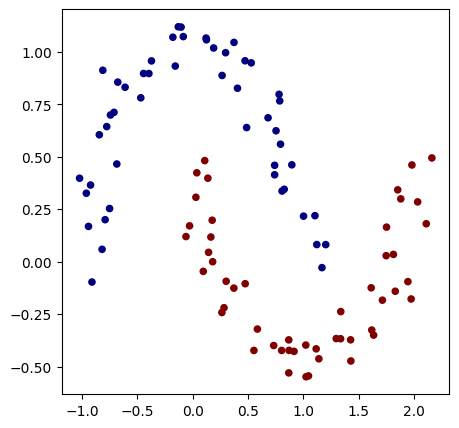

In [ ]:

y =     y*2 - 1

plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

#init Model

In [52]:
# 2 input layers
# tow hidden layers with 17_Neurons
# 1 output layer
model = MLP(2, [17, 17, 1])
print(model)
print('num of para', len(model.parameters()))


MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(17), ReLUNeuron(17), ReLUNeuron(17), ReLUNeuron(17), ReLUNeuron(17), ReLUNeuron(17), ReLUNeuron(17), ReLUNeuron(17), ReLUNeuron(17), ReLUNeuron(17), ReLUNeuron(17), ReLUNeuron(17), ReLUNeuron(17), ReLUNeuron(17), ReLUNeuron(17), ReLUNeuron(17), ReLUNeuron(17)], Layer of [LinearNeuron(17)]]
num of para 375


#Loss Func

In [54]:
!pip install micrograd

In [56]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP
## its giving me this annoying + int error and i just importuse micrograd
"""
def loss(batchSiz=None):
    if batchSiz is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batchSiz]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow) for xrow in Xb)]

    scores = list(map(model, inputs))

    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    dataLoss = sum(losses) * (1.0 / len(losses))

    alpha = 1e-4
    regLoss = alpha * sum((p*p for p in model.parameters()))
    totalLoss = dataLoss + regLoss

    acc = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return totalLoss, sum(acc) / len(acc)


totalLoss, acc = loss()

print(totalLoss, acc)
"""

def loss(batch_size=None):

    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]

    # forward the model to get scores
    scores = list(map(model, inputs))

    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss

    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=2.3202226384324462, grad=0) 0.49


#Optimizing

In [58]:
for j in range(100):
    totalLoss, acc = loss()

    model.zero_grad()
    totalLoss.backward()

    learningRate = 1.0 - 0.9*j/100
    for p in model.parameters():
        p.data -= learningRate * p.grad

    if j % 1 == 0:
        print(f"step {j} loss {totalLoss.data}, accuracy {acc*100}%")



step 0 loss 0.510932240613985, accuracy 50.0%
step 1 loss 0.510927868155029, accuracy 50.0%
step 2 loss 0.5109235367773745, accuracy 50.0%
step 3 loss 0.5109192464334814, accuracy 50.0%
step 4 loss 0.5109149970762722, accuracy 50.0%
step 5 loss 0.5109107886591301, accuracy 50.0%
step 6 loss 0.5109066211358988, accuracy 50.0%
step 7 loss 0.5109024944608814, accuracy 50.0%
step 8 loss 0.5108984085888395, accuracy 50.0%
step 9 loss 0.5108943634749927, accuracy 50.0%
step 10 loss 0.5108903590750176, accuracy 50.0%
step 11 loss 0.5108863953450465, accuracy 50.0%
step 12 loss 0.5108824722416676, accuracy 50.0%
step 13 loss 0.5108785897219235, accuracy 50.0%
step 14 loss 0.5108747477433103, accuracy 50.0%
step 15 loss 0.5108709462637776, accuracy 50.0%
step 16 loss 0.5108671852417269, accuracy 50.0%
step 17 loss 0.5108634646360113, accuracy 50.0%
step 18 loss 0.5108597844059345, accuracy 50.0%
step 19 loss 0.5108561445112503, accuracy 50.0%
step 20 loss 0.5108525449121619, accuracy 50.0%
step

#Visualize Decision Bouandry

(-1.6708631651078416, 2.079136834892158)

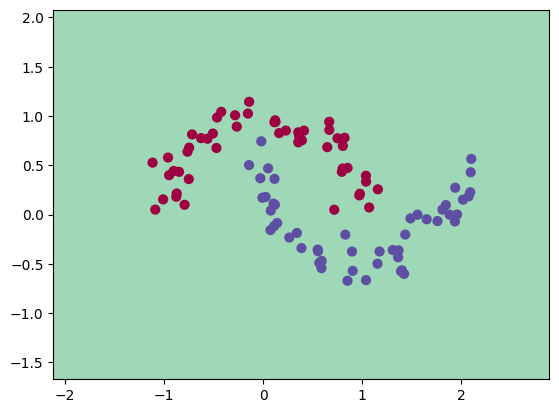

In [62]:

h = 0.25
xMin, xMax = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(xMin, xMax, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())